# Integration

Research in astrophysics frequently involves evaluating integrals numerically. The basic idea behind numerical "quadrature" is that a definite integral of a function can be approximated by a sum over evaluations of that function multiplied by quadrature "weights":

\begin{equation}
    \int_a^b f(x)\text{d}x \approx \sum_n w_n f(x_n), \hspace{1em} x_n\in[a,b]
\end{equation}

Depending on the function $f$, different choices of weights $w_n$ and grid-points $x_n$ can lead to improvements in accuracy (to floating-point error, in some cases). 

One of the simplest quadratures, known as the trapezoidal rule, approximates a definite integral as the sum of the areas of trapezoids defined by the endpoints of line segments along the curve defined by $f$:

\begin{align}
    \int_a^b f(x)\text{d}x 
    &\approx \sum_N \text{[area of trapezoid defined by the four points }(x_n,0),(x_n,f(x_n)),(x_{n+1},0),(x_{n+1},f(x_{n+1}))],
\\
    &=\sum_{n=0}^{N-2}\frac{1}{2}(x_{n+1}-x_n)[f(x_n) + f(x_{n+1})]
\end{align}

on an interval with $N$ grid-points $x_0,...,x_{N-1}$. For a grid of evenly spaced points with grid-size $\Delta x$, this simplifies further to

\begin{equation}
    \int_a^b f(x)\text{d}x 
    \approx\Delta x
    \left[ 
        \frac{1}{2}f(x_0) + f(x_1) + ... + f(x_{N-2}) + \frac{1}{2}f(x_{N-1})
    \right].
\end{equation}

Here's an example of a function that applies the trapezoidal rule to integrate a function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def trapz_int(f,a,b,tol=1e-10,maxits=100):
    '''
        uses the trapezoidal rule to compute the definite integral 
        int_a^b f(x)dx, iteratively increasing the number of grid
        points used for quadrature until the solution converges
        
        Inputs:
            f       function to integrate
            a       starting point of integration
            b       en-point of integration
            tol     tolerance for change in subsequent iterations
            maxits  maximum number of iterations
        Outputs:
            I       definite integral int_a^b f(x)dx
    '''
    # evaluate initial approximation to the integral:
    dx= (b-a)                  # coursest possible grid-spacing
    I = dx*(f(b)/2. + f(a)/2.) # roughest approximation to integral
    N = 2                      # smallest number of grid-pointsS
    
    # iteratively refine by halving the grid-spacing:
    itr= 0
    while itr<maxits:
        dx_new = dx/2. # decrease grid-spacing
        N += 2**itr    # increase number of grid-points
        x_eval = np.linspace(a,b,N)[1:-1][::2] # this indexing takes only the grid-points we haven't evaluated yet
        I_new = I*dx_new/dx \
              + np.sum(f(x_eval))*dx_new
        print(f'iteration {itr} ({N} points): {100*(I_new-I)/I:.4e}% change')
        if abs(I_new-I)<tol:
            break        
        itr+=1
        dx = dx_new
        I = I_new

    if itr==maxits:
        print(f'integral did not converge after {itr} refinements')
    else:
        print('integral converged!')
    return I

Let's use this function to calculate the integral $\int_0^5 dx (x^2 + 3)$, which has the exact answer $5^3 / 3 + 3\times5\simeq 56.667$:

In [2]:
%%time
ans = 5.**3 / 3 + 3 * 5.
tst = trapz_int(f=lambda x: x**2 + 3,a=0,b=5,tol=1e-10)
print(tst)
print(f'error of {(ans - tst)/ans*100:.4e}% ')

iteration 0 (3 points): -2.0161e+01% change
iteration 1 (5 points): -6.3131e+00% change
iteration 2 (9 points): -1.6846e+00% change
iteration 3 (17 points): -4.2838e-01% change
iteration 4 (33 points): -1.0755e-01% change
iteration 5 (65 points): -2.6918e-02% change
iteration 6 (129 points): -6.7312e-03% change
iteration 7 (257 points): -1.6829e-03% change
iteration 8 (513 points): -4.2074e-04% change
iteration 9 (1025 points): -1.0518e-04% change
iteration 10 (2049 points): -2.6296e-05% change
iteration 11 (4097 points): -6.5740e-06% change
iteration 12 (8193 points): -1.6435e-06% change
iteration 13 (16385 points): -4.1088e-07% change
iteration 14 (32769 points): -1.0272e-07% change
iteration 15 (65537 points): -2.5680e-08% change
iteration 16 (131073 points): -6.4200e-09% change
iteration 17 (262145 points): -1.6050e-09% change
iteration 18 (524289 points): -4.0125e-10% change
iteration 19 (1048577 points): -1.0031e-10% change
integral converged!
56.66666666674246
error of -1.3375e-

This converged reasonably well, but it required evaluating our function at a lot of points. Scipy includes a wrapper for a Fortran routine that uses a much more accurate, and also efficient quadrature (see https://en.wikipedia.org/wiki/Gaussian_quadrature):

In [3]:
from scipy.integrate import quad
quad?

In [4]:
%%time 
I, err = quad(func=lambda x: x**2 + 3, a=0, b=5, epsabs=1.e-15)
print (I, err)

56.66666666666666 6.29126380620922e-13
CPU times: user 64 µs, sys: 7 µs, total: 71 µs
Wall time: 72.7 µs


### Integration of a pre-sampled function

In astrophysics we frequently need to calculate the area under the curve of a function pre-sampled at fixed points. The approach to integrating over a pre-sampled function isn't any different in principle, but we no longer have the option of iteratively refining our answer until the solution converges. 

### Exercise
Write a function, called trapz_fixed_int(f,x), that takes as input an array of samples $f$ of a function $f$ at an array of grid-points $x$, and uses the trapezoidal rule to compute the definite integral $\int_a^bf\text{d}x$, where $a$ and $b$ are the end-points $x[0]$ and $x[-1]$. Use the same number of grid-points used in the final iteration of trapz_int above, and compare with the analytical answer:

In [7]:
xx = np.linspace(0,5,1048577) # the largest number of grid-points used in trapz_int before
ans = 5.**3 / 3 + 3 * 5.

Scipy also includes some ready-to-use functions for integrating over pre-sampled points:

In [5]:
from scipy.integrate import trapezoid,simpson

In [8]:
%%time 
# this should give the same answer as result from exercise
tst= trapezoid(y=xx**2 + 3,x=xx)
print(tst)
print(f'error of {(ans - tst)/ans*100:.4e}% ')

56.666666666685714
error of -3.3617e-11% 
CPU times: user 5.75 ms, sys: 4.38 ms, total: 10.1 ms
Wall time: 9.15 ms


In [9]:
%%time 
tst= simpson(y=xx**2 + 3,x=xx)
print(tst)
print(f'error of {(ans - tst)/ans*100:.4e}% ')

56.66666666666664
error of 3.7617e-14% 
CPU times: user 14.4 ms, sys: 3.83 ms, total: 18.2 ms
Wall time: 17.5 ms


# Interpolation

We often have data sampled at a relatively small number of points, and so we need to interpolate between them. In other cases, we may need to downsample from high to lower resolution. There are a number of different ways to interpolate functions. Scipy has a few built-in options:

In [11]:
from scipy.interpolate import interp1d,CubicSpline,splrep,splev

Let's try interpolating the function $f(x) = e^{-x}  \sin(2  \pi  x)$ using only a small number of points:

In [12]:
# define and sample the function at a small number of points
def myf(x):
    return (np.exp(-x)) * np.sin(2 * np.pi * x)
x_coarse = np.linspace(0,2,8)
data = myf(x_coarse)

# construct interpolation functions:
linterp = interp1d(x=x_coarse,y=data,kind='linear')
splterp = splrep(x=x_coarse,y=data)
csplterp= CubicSpline(x=x_coarse,y=data)

The above calls to scipy's interpolation functions return new functions that we can then evaluate at our desired grid-points:

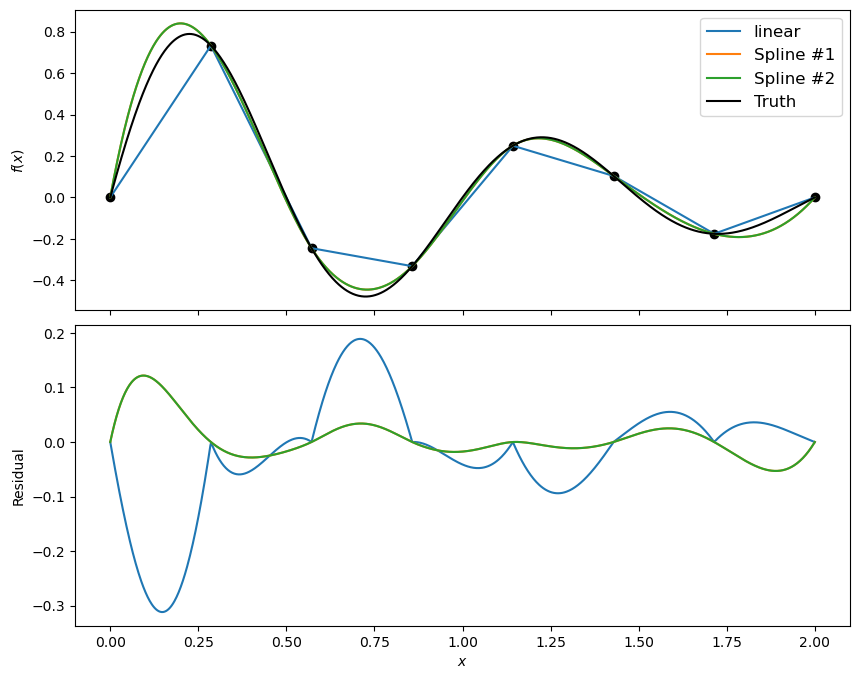

In [13]:
# evaluate and plot the interpolation functions
x_fine = np.linspace(0,2,1000) 
truth = myf(x_fine)

f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
ax[0].plot(x_coarse,data,'ko')
ax[0].plot(x_fine,linterp(x_fine),label='linear')
ax[0].plot(x_fine,csplterp(x_fine),label='Spline #1')
ax[0].plot(x_fine,splev(x_fine,splterp),label='Spline #2')
ax[0].plot(x_fine,truth,'k',label='Truth')
ax[0].legend(fontsize=12)
ax[0].set_ylabel('$f(x)$')

# now plot residuals from the function evaluation:
for terp in [linterp(x_fine),csplterp(x_fine),splev(x_fine,splterp)]:
    ax[1].plot(x_fine,terp - truth)
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('$x$')
plt.subplots_adjust(hspace=0.05)

None of these are perfect, so be careful not to trust interpolation too much! 